### FactRuEval example (uncased model)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import sys

sys.path.append("../")

warnings.filterwarnings("ignore")

### 0. Download pretrained elmo model
Download pretrained ELMo for [russian](http://vectors.nlpl.eu/repository/11/170.zip) from [implementation](https://github.com/HIT-SCIR/ELMoForManyLangs) of elmo in pytorch and unzip.


In [2]:
import os


data_path = "/home/lis/ner/ulmfit/data/factrueval/"
train_path = os.path.join(data_path, "train_with_pos.csv")
valid_path = os.path.join(data_path, "valid_with_pos.csv")
model_dir = "/datadrive/elmo/"
config_name = "cnn_50_100_512_4096_sample.json"

In [3]:
import torch
torch.cuda.set_device(1)
torch.cuda.is_available(), torch.cuda.current_device()

(True, 1)

### 1. Data preparation

Data train and validation should be presented in the following format.

In [4]:
import pandas as pd


df = pd.read_csv(train_path)
df.head()

,0,1,3
0,O O O O O O O O O O O O O O O O O O O O,"Мифология солнцеворота , собственно , и сводит...",NOUN NOUN PNCT ADVB PNCT CONJ VERB PREP NOUN N...
1,O O O O O O B_ORG I_ORG O B_ORG I_ORG O O O O ...,"По его словам , с покупкой Caramba TV « СТС Ме...",PREP NPRO NOUN PNCT PREP NOUN <unk> <unk> PNCT...
2,O O O O O O O O O O O O O O O O B_LOC O,"Такое десятилетие , по его словам « необходимо...",ADJF NOUN PNCT PREP NPRO NOUN PNCT ADJS ADJF P...
3,O O O O O O O O O O O O O O,"Правительство уволило часть врачей , обвинив и...",NOUN VERB NOUN NOUN PNCT GRND NPRO PREP NOUN N...
4,O O O B_PER I_PER O O O O O O B_ORG I_ORG I_OR...,Министр сельского хозяйства Николай Федоров пр...,NOUN ADJF NOUN NOUN NOUN VERB PNCT CONJ PRTF V...


Train and valid .csv files must have columns named (0, 1). Column 3 is't necessary (does not used now).
* Column 0 contains labels in IOB format.
* Column 1 contains tokenized and separated (by whitespace) text.

For using data in model we need to create `NerData` object.

* `train_path` - path to train .csv file
* `valid_path` - path to valid .csv file
* `model_dir` - path to ELMo pretrained model's dir
* `config_name` - name of config in `model_dir` folder
* `batch_size` - batch size (default `16`)
* `cuda` - using cuda or cpu (default `True`)
* `is_cls` - create data for joint model (default `False`)
* `oov` - default unknown in ELMo model (default `'<oov>'`)
* `pad` - default pad sym in ELMo model (default `'<pad>'`)

In [41]:
from modules.data.elmo_data import ElmoNerData as NerData

In [44]:
data = NerData.create(train_path, valid_path, model_dir, config_name)

For factrueval we use the following sample of labels:

In [6]:
print(data.label2idx)

{'<pad>': 0, '<bos>': 1, '<eos>': 2, 'O': 3, 'B_ORG': 4, 'I_ORG': 5, 'B_LOC': 6, 'B_PER': 7, 'I_PER': 8, 'I_LOC': 9}


### 2. Create model
For creating pytorch model we need to create `NerModel` object.

* `label_size` - number of labels: `len(data.label2idx)`,

ElmoEmbedder params
* `model_dir` - path to ELMo pretrained model's dir
* `config_name` - name of config in `model_dir` folder
* `embedding_dim` - output dim from bert model (default `768`)
* `elmo_mode` - mode of how bert output will be returned. If `avg` return mean of all outputs from ELMo. If `weighted` return weighted sum of all bert output layers, weights are learnable (aka ELMO).
* `freeze` - freezing bert model (default `True`)

ElmoBiLSTMEncoder params
* `enc_hidden_dim` - dim of rnn layer or hidden layer (default `128`)
* `rnn_layers` - number of rnn layers in encoder

CRFDecoder params
* `input_dropout` - dropout param (default `0.5`),

Gpu or cpu:
* `use_cuda` - use cuda or cpu (default `True`).

In [9]:
from modules.models.elmo_models import ElmoBiLSTMCRF

In [10]:
model = ElmoBiLSTMCRF.create(len(data.label2idx), model_dir, config_name, enc_hidden_dim=128, freeze=False)

INFO:root:char embedding size: 3896
INFO:root:word embedding size: 329681


In [11]:
model.decoder

CRFDecoder(
  (input_dropout): Dropout(p=0.5)
  (linear): Linears(
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=64, bias=True)
    )
    (output_linear): Linear(in_features=64, out_features=10, bias=True)
  )
  (crf): CRF()
)

### 3. Create learner

For training our pytorch model we need to create `NerLearner` object.

* `model: NerModel` - pytorch model
* `data: NerData` - train and valid dataloaders
* `best_model_path` - path for store best model
* `lr` - starting learning rate (default `0.001`)
* `betas` - params for default optimizer (default `[0.8, 0.9]`)
* `clip` - grad clipping (default `5`)
* `verbose` - printing to console reports (default `True`)
* `sup_labels` - list of supported labels for calculating `target_metric` metric. For FactRuEval use: `['B_LOC', 'I_LOC', 'B_ORG', 'I_ORG', 'B_PER', 'I_PER']` (default `None`)
* `t_total` - total optimization steps, used for lr scheduler, if -1, don't scale lr after batch iteration (default `-1`), usally t_total = num_epochs * train_size / batch_size
* `warmup` - portion of t_total for the warmup, -1  means no warmup (default `0.1`)
* `weight_decay` - weight decay (default `0.01`)

In [40]:
from modules import NerLearner

In [19]:
num_epochs = 100
learner = NerLearner(model, data,
                     best_model_path="/datadrive/models/factrueval/elmo_bilmcrf.cpt",
                     lr=0.0001, clip=1.0, sup_labels=data.id2label[4:],
                     t_total=num_epochs * len(data.train_dl))

### 4. Learn your NER model
Call `learner.fit`
* `epochs` - number of train iterations (default `100`)
* `resume_history` - resuming appending results to history or create new (default `True`)
* `target_metric` - mean metric, that want you see to pick best epochs (default `f1`).

In [20]:
learner.fit(1, target_metric='f1')

INFO:root:Resuming train... Current epoch 0.


INFO:root:
epoch 1, average train epoch loss=10.427



INFO:root:on epoch 0 by max_f1: 0.089
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.538     0.027     0.051       260
       I_ORG      0.181     0.046     0.073       283
       B_LOC      0.833     0.026     0.050       195
       B_PER      0.706     0.126     0.213       191
       I_PER      0.353     0.092     0.146       130
       I_LOC      0.000     0.000     0.000        35

   micro avg      0.384     0.056     0.097      1094
   macro avg      0.435     0.053     0.089      1094
weighted avg      0.488     0.056     0.095      1094



Fit for the best model

In [ ]:
learner.fit(num_epochs - 1, True, target_metric='f1')

INFO:root:Resuming train... Current epoch 1.


INFO:root:
epoch 2, average train epoch loss=10.293



INFO:root:on epoch 1 by max_f1: 0.093
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.556     0.038     0.072       260
       I_ORG      0.187     0.049     0.078       283
       B_LOC      0.625     0.026     0.049       195
       B_PER      0.590     0.120     0.200       191
       I_PER      0.371     0.100     0.158       130
       I_LOC      0.000     0.000     0.000        35

   micro avg      0.371     0.059     0.102      1094
   macro avg      0.388     0.056     0.093      1094
weighted avg      0.439     0.059     0.100      1094



INFO:root:
epoch 3, average train epoch loss=9.8236



INFO:root:on epoch 2 by max_f1: 0.132
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.462     0.046     0.084       260
       I_ORG      0.206     0.078     0.113       283
       B_LOC      0.750     0.062     0.114       195
       B_PER      0.559     0.173     0.264       191
       I_PER      0.413     0.146     0.216       130
       I_LOC      0.000     0.000     0.000        35

   micro avg      0.386     0.090     0.145      1094
   macro avg      0.398     0.084     0.132      1094
weighted avg      0.443     0.090     0.141      1094



INFO:root:
epoch 4, average train epoch loss=8.9581



INFO:root:on epoch 3 by max_f1: 0.218
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.446     0.096     0.158       260
       I_ORG      0.266     0.177     0.212       283
       B_LOC      0.653     0.251     0.363       195
       B_PER      0.554     0.267     0.360       191
       I_PER      0.364     0.154     0.216       130
       I_LOC      0.000     0.000     0.000        35

   micro avg      0.416     0.178     0.250      1094
   macro avg      0.381     0.157     0.218      1094
weighted avg      0.431     0.178     0.246      1094



INFO:root:
epoch 5, average train epoch loss=7.8177



INFO:root:on epoch 4 by max_f1: 0.336
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.561     0.265     0.360       260
       I_ORG      0.296     0.258     0.275       283
       B_LOC      0.656     0.626     0.640       195
       B_PER      0.496     0.293     0.368       191
       I_PER      0.593     0.269     0.370       130
       I_LOC      0.000     0.000     0.000        35

   micro avg      0.484     0.324     0.388      1094
   macro avg      0.434     0.285     0.336      1094
weighted avg      0.484     0.324     0.379      1094



INFO:root:
epoch 6, average train epoch loss=6.6099



INFO:root:on epoch 5 by max_f1: 0.389
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.554     0.415     0.475       260
       I_ORG      0.374     0.290     0.327       283
       B_LOC      0.700     0.754     0.726       195
       B_PER      0.424     0.319     0.364       191
       I_PER      0.608     0.346     0.441       130
       I_LOC      0.000     0.000     0.000        35

   micro avg      0.513     0.405     0.453      1094
   macro avg      0.443     0.354     0.389      1094
weighted avg      0.499     0.405     0.443      1094



INFO:root:
epoch 7, average train epoch loss=5.4815



INFO:root:on epoch 6 by max_f1: 0.461
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.617     0.508     0.557       260
       I_ORG      0.494     0.424     0.456       283
       B_LOC      0.714     0.779     0.745       195
       B_PER      0.511     0.372     0.430       191
       I_PER      0.673     0.508     0.579       130
       I_LOC      0.000     0.000     0.000        35

   micro avg      0.573     0.495     0.531      1094
   macro avg      0.501     0.432     0.461      1094
weighted avg      0.571     0.495     0.527      1094



INFO:root:
epoch 8, average train epoch loss=4.3492



INFO:root:on epoch 7 by max_f1: 0.61
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.669     0.677     0.673       260
       I_ORG      0.632     0.473     0.541       283
       B_LOC      0.791     0.795     0.793       195
       B_PER      0.803     0.812     0.807       191
       I_PER      0.882     0.808     0.843       130
       I_LOC      0.000     0.000     0.000        35

   micro avg      0.733     0.663     0.696      1094
   macro avg      0.630     0.594     0.610      1094
weighted avg      0.709     0.663     0.682      1094



INFO:root:
epoch 9, average train epoch loss=3.3389



INFO:root:on epoch 8 by max_f1: 0.658
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.724     0.708     0.716       260
       I_ORG      0.692     0.611     0.649       283
       B_LOC      0.830     0.826     0.828       195
       B_PER      0.833     0.937     0.882       191
       I_PER      0.916     0.838     0.876       130
       I_LOC      0.000     0.000     0.000        35

   micro avg      0.780     0.737     0.758      1094
   macro avg      0.666     0.653     0.658      1094
weighted avg      0.753     0.737     0.744      1094



INFO:root:
epoch 10, average train epoch loss=2.5398



INFO:root:on epoch 9 by max_f1: 0.685
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.744     0.762     0.753       260
       I_ORG      0.735     0.668     0.700       283
       B_LOC      0.866     0.862     0.864       195
       B_PER      0.862     0.948     0.903       191
       I_PER      0.926     0.862     0.892       130
       I_LOC      0.000     0.000     0.000        35

   micro avg      0.805     0.775     0.790      1094
   macro avg      0.689     0.683     0.685      1094
weighted avg      0.782     0.775     0.778      1094



INFO:root:
epoch 11, average train epoch loss=1.9537



INFO:root:on epoch 10 by max_f1: 0.713
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.777     0.804     0.790       260
       I_ORG      0.775     0.693     0.731       283
       B_LOC      0.851     0.877     0.864       195
       B_PER      0.910     0.953     0.931       191
       I_PER      0.950     0.885     0.916       130
       I_LOC      0.111     0.029     0.045        35

   micro avg      0.830     0.799     0.814      1094
   macro avg      0.729     0.707     0.713      1094
weighted avg      0.812     0.799     0.804      1094



INFO:root:
epoch 12, average train epoch loss=1.6208



INFO:root:on epoch 11 by max_f1: 0.766
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.809     0.800     0.805       260
       I_ORG      0.820     0.710     0.761       283
       B_LOC      0.855     0.877     0.866       195
       B_PER      0.934     0.958     0.946       191
       I_PER      0.952     0.923     0.938       130
       I_LOC      0.467     0.200     0.280        35

   micro avg      0.857     0.814     0.835      1094
   macro avg      0.806     0.745     0.766      1094
weighted avg      0.848     0.814     0.828      1094



INFO:root:
epoch 13, average train epoch loss=1.2925



INFO:root:on epoch 12 by max_f1: 0.811
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.798     0.819     0.808       260
       I_ORG      0.842     0.735     0.785       283
       B_LOC      0.890     0.872     0.881       195
       B_PER      0.939     0.963     0.951       191
       I_PER      0.945     0.923     0.934       130
       I_LOC      0.625     0.429     0.508        35

   micro avg      0.865     0.832     0.848      1094
   macro avg      0.840     0.790     0.811      1094
weighted avg      0.862     0.832     0.845      1094



INFO:root:
epoch 14, average train epoch loss=1.0895



INFO:root:on epoch 13 by max_f1: 0.825
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.790     0.838     0.813       260
       I_ORG      0.823     0.756     0.788       283
       B_LOC      0.881     0.872     0.876       195
       B_PER      0.948     0.963     0.956       191
       I_PER      0.953     0.938     0.946       130
       I_LOC      0.643     0.514     0.571        35

   micro avg      0.858     0.846     0.852      1094
   macro avg      0.840     0.814     0.825      1094
weighted avg      0.857     0.846     0.851      1094



INFO:root:
epoch 15, average train epoch loss=0.89711



INFO:root:on epoch 14 by max_f1: 0.831
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.797     0.831     0.814       260
       I_ORG      0.861     0.721     0.785       283
       B_LOC      0.882     0.882     0.882       195
       B_PER      0.948     0.958     0.953       191
       I_PER      0.961     0.938     0.949       130
       I_LOC      0.679     0.543     0.603        35

   micro avg      0.872     0.837     0.854      1094
   macro avg      0.855     0.812     0.831      1094
weighted avg      0.871     0.837     0.852      1094



INFO:root:
epoch 16, average train epoch loss=0.74681



INFO:root:on epoch 14 by max_f1: 0.831


              precision    recall  f1-score   support

       B_ORG      0.790     0.838     0.813       260
       I_ORG      0.805     0.760     0.782       283
       B_LOC      0.885     0.872     0.879       195
       B_PER      0.953     0.958     0.956       191
       I_PER      0.961     0.946     0.953       130
       I_LOC      0.633     0.543     0.585        35

   micro avg      0.855     0.848     0.852      1094
   macro avg      0.838     0.820     0.828      1094
weighted avg      0.855     0.848     0.851      1094



INFO:root:
epoch 17, average train epoch loss=0.63229



INFO:root:on epoch 16 by max_f1: 0.835
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.795     0.835     0.814       260
       I_ORG      0.831     0.763     0.796       283
       B_LOC      0.881     0.872     0.876       195
       B_PER      0.953     0.953     0.953       191
       I_PER      0.960     0.931     0.945       130
       I_LOC      0.690     0.571     0.625        35

   micro avg      0.864     0.846     0.855      1094
   macro avg      0.852     0.821     0.835      1094
weighted avg      0.863     0.846     0.854      1094



INFO:root:
epoch 18, average train epoch loss=0.54294



INFO:root:on epoch 17 by max_f1: 0.839
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.808     0.823     0.815       260
       I_ORG      0.855     0.753     0.801       283
       B_LOC      0.887     0.887     0.887       195
       B_PER      0.953     0.963     0.958       191
       I_PER      0.961     0.938     0.949       130
       I_LOC      0.690     0.571     0.625        35

   micro avg      0.875     0.846     0.861      1094
   macro avg      0.859     0.823     0.839      1094
weighted avg      0.874     0.846     0.859      1094



INFO:root:
epoch 19, average train epoch loss=0.44378



INFO:root:on epoch 18 by max_f1: 0.84
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.797     0.831     0.814       260
       I_ORG      0.819     0.784     0.801       283
       B_LOC      0.858     0.867     0.862       195
       B_PER      0.958     0.948     0.953       191
       I_PER      0.976     0.946     0.961       130
       I_LOC      0.639     0.657     0.648        35

   micro avg      0.857     0.854     0.855      1094
   macro avg      0.841     0.839     0.840      1094
weighted avg      0.858     0.854     0.856      1094



INFO:root:
epoch 20, average train epoch loss=0.38945



INFO:root:on epoch 19 by max_f1: 0.854
INFO:root:Saving new best model...


              precision    recall  f1-score   support

       B_ORG      0.806     0.831     0.818       260
       I_ORG      0.872     0.770     0.818       283
       B_LOC      0.877     0.877     0.877       195
       B_PER      0.958     0.963     0.961       191
       I_PER      0.961     0.946     0.953       130
       I_LOC      0.706     0.686     0.696        35

   micro avg      0.877     0.856     0.866      1094
   macro avg      0.863     0.846     0.854      1094
weighted avg      0.878     0.856     0.866      1094



INFO:root:
epoch 21, average train epoch loss=0.32141



INFO:root:on epoch 19 by max_f1: 0.854


              precision    recall  f1-score   support

       B_ORG      0.786     0.846     0.815       260
       I_ORG      0.851     0.767     0.807       283
       B_LOC      0.872     0.877     0.875       195
       B_PER      0.958     0.963     0.961       191
       I_PER      0.969     0.954     0.961       130
       I_LOC      0.710     0.629     0.667        35

   micro avg      0.867     0.857     0.862      1094
   macro avg      0.858     0.839     0.847      1094
weighted avg      0.868     0.857     0.862      1094



INFO:root:
epoch 22, average train epoch loss=0.28334



INFO:root:on epoch 19 by max_f1: 0.854


              precision    recall  f1-score   support

       B_ORG      0.801     0.838     0.820       260
       I_ORG      0.882     0.763     0.818       283
       B_LOC      0.864     0.882     0.873       195
       B_PER      0.958     0.958     0.958       191
       I_PER      0.961     0.946     0.953       130
       I_LOC      0.733     0.629     0.677        35

   micro avg      0.877     0.854     0.865      1094
   macro avg      0.867     0.836     0.850      1094
weighted avg      0.878     0.854     0.864      1094



INFO:root:
epoch 23, average train epoch loss=0.24262



INFO:root:on epoch 19 by max_f1: 0.854


              precision    recall  f1-score   support

       B_ORG      0.827     0.846     0.837       260
       I_ORG      0.894     0.777     0.832       283
       B_LOC      0.876     0.872     0.874       195
       B_PER      0.963     0.958     0.961       191
       I_PER      0.961     0.946     0.953       130
       I_LOC      0.657     0.657     0.657        35

   micro avg      0.887     0.858     0.872      1094
   macro avg      0.863     0.843     0.852      1094
weighted avg      0.887     0.858     0.872      1094



INFO:root:
epoch 24, average train epoch loss=0.20977



INFO:root:on epoch 19 by max_f1: 0.854


              precision    recall  f1-score   support

       B_ORG      0.809     0.831     0.820       260
       I_ORG      0.892     0.760     0.821       283
       B_LOC      0.881     0.872     0.876       195
       B_PER      0.958     0.963     0.961       191
       I_PER      0.969     0.946     0.957       130
       I_LOC      0.667     0.629     0.647        35

   micro avg      0.883     0.850     0.866      1094
   macro avg      0.863     0.833     0.847      1094
weighted avg      0.884     0.850     0.865      1094



INFO:root:
epoch 25, average train epoch loss=0.19112



INFO:root:on epoch 19 by max_f1: 0.854


              precision    recall  f1-score   support

       B_ORG      0.821     0.846     0.833       260
       I_ORG      0.874     0.784     0.827       283
       B_LOC      0.890     0.872     0.881       195
       B_PER      0.953     0.963     0.958       191
       I_PER      0.968     0.938     0.953       130
       I_LOC      0.667     0.629     0.647        35

   micro avg      0.883     0.859     0.871      1094
   macro avg      0.862     0.839     0.850      1094
weighted avg      0.883     0.859     0.870      1094



In [37]:
from modules.utils.plot_metrics import plot_by_class_curve

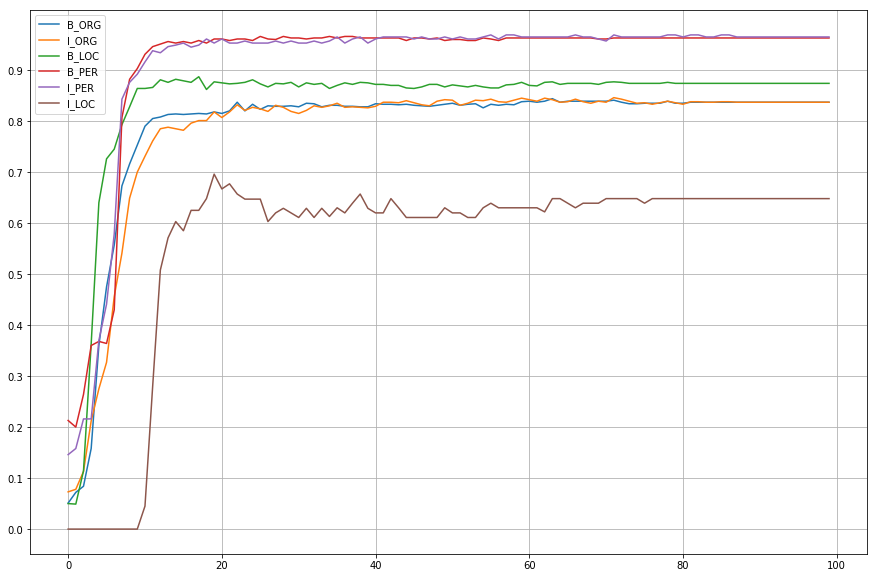

In [34]:
plot_by_class_curve(learner.history, "f1", learner.sup_labels)

### 5. Predict on new data
Create new data loader from existing path.

In [38]:
from modules.data.elmo_data import get_elmo_data_loader_for_predict

In [24]:
dl = get_elmo_data_loader_for_predict(data_path + "valid_with_pos.csv", learner)

Load our best model.

In [25]:
learner.load_model()

Call predict from learner.

In [39]:
preds = learner.predict(dl)

### 6. Transform predictions to tokens and spans

In [27]:
from modules.utils.utils import tokens2spans


tp, lp = [x.tokens for x in dl.dataset], preds
print(tp[0])
print(lp[0])

['<bos>', 'Сделка', 'состоится', ',', 'если', 'будет', 'одобрена', 'регуляторами', ',', 'из-за', 'которых', 'в', 'начале', 'года', 'сорвалось', 'слияние', 'NYSE', 'Euronext', 'с', 'Deutsche', 'Börse', '<eos>']
['<bos>', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ORG', 'I_ORG', 'O', 'B_ORG', 'I_ORG', '<eos>']


In [28]:
sp = tokens2spans(tp, lp)

In [29]:
print(sp[0])

[('<bos>', '<bos>'), ('Сделка', 'O'), ('состоится', 'O'), (',', 'O'), ('если', 'O'), ('будет', 'O'), ('одобрена', 'O'), ('регуляторами', 'O'), (',', 'O'), ('из-за', 'O'), ('которых', 'O'), ('в', 'O'), ('начале', 'O'), ('года', 'O'), ('сорвалось', 'O'), ('слияние', 'O'), ('NYSE Euronext', 'ORG'), ('с', 'O'), ('Deutsche Börse', 'ORG')]


### 7. Evaluate

IOB precision

In [30]:
from modules.train.train import validate_step
print(validate_step(learner.data.valid_dl, learner.model, learner.data.id2label, learner.sup_labels))

              precision    recall  f1-score   support

       B_ORG      0.821     0.862     0.841       260
       I_ORG      0.917     0.784     0.846       283
       B_LOC      0.877     0.877     0.877       195
       B_PER      0.963     0.963     0.963       191
       I_PER      0.977     0.962     0.969       130
       I_LOC      0.639     0.657     0.648        35

   micro avg      0.891     0.867     0.879      1094
   macro avg      0.866     0.851     0.857      1094
weighted avg      0.893     0.867     0.879      1094



Span precision

In [31]:
from modules.utils.plot_metrics import get_elmo_span_report
clf_report = get_elmo_span_report(dl, preds)
print(clf_report)

              precision    recall  f1-score   support

         PER      0.880     0.885     0.883       191
         LOC      0.773     0.785     0.779       195
         ORG      0.760     0.815     0.787       260

   micro avg      0.798     0.827     0.812       646
   macro avg      0.804     0.828     0.816       646
weighted avg      0.799     0.827     0.813       646

